In [1]:
%load_ext autoreload

In [2]:
%autoreload
from mine.models.mine import Mine
import torch.nn as nn
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

Device: cuda


In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 1024


# USE 100K TEST DATA
dataset = torchvision.datasets.ImageFolder(
    root='/scratch/network/ls1546/imagenet/ILSVRC/Data/CLS-LOC/test', 
    transform=transform
)

# load part of dataset
indices = torch.arange(20000)
dataset_half = torch.utils.data.Subset(dataset, indices)
dataloader = torch.utils.data.DataLoader(dataset_half, batch_size=batch_size, shuffle=True, num_workers=2)

# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

cuda:1


In [4]:
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights=weights).to(device)
model;

In [5]:
# add hooks, run model with inputs to get activations

# a dict to store the activations
activation = {}
def get_activation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach().cpu().numpy()
        # activation[name] = output.numpy()
    return hook

hook_layer1 = model.layer1[0].conv1.register_forward_hook(get_activation('conv1'))
# hook_relu = model.layer1[0].relu.register_forward_hook(get_activation('relu'))
hook_layer4 = model.layer4[1].conv2.register_forward_hook(get_activation('conv2'))

In [6]:
inputs_list = []
conv_list = []
# relu_list = []
conv2_list = []

for inputs, _ in tqdm(dataloader):
    
    inputs = inputs.to(device)

    with torch.no_grad():
        output = model(inputs)
        
        # collect the activations
        conv_list.append(activation['conv1'])
        # relu_list.append(activation['relu'])
        conv2_list.append(activation['conv2'])

        inputs = inputs.detach().cpu().numpy()
        # inputs = inputs.numpy()
        inputs_list.append(inputs)

    del inputs

# detach the hooks
hook_layer1.remove()
# hook_relu.remove()
hook_layer4.remove()

100%|█████████████████████████████████████████| 20/20 [02:23<00:00,  7.19s/it]


In [7]:
act_length = (len(conv_list) - 1)*batch_size + len(conv_list[len(conv_list)-1])
act_length

20000

In [8]:
images_flat = np.zeros((act_length, 224*224*3))
responses = np.zeros((act_length, 1))
x_dim=224*224*3
y_dim=1

# location of activation response on image (here center x and y pos)
c1 = 56//2

# which filter (here first (0))
filter = 0

for batch in range(len(conv_list)):
    for image in range(len(conv_list[batch])):
        responses[batch*len(conv_list[0])+image, 0] = conv_list[batch][image, filter, c1, c1]
        images_flat[batch*len(conv_list[0])+image, :] = inputs_list[batch][image].flatten()

In [9]:
del conv_list
del inputs_list

In [10]:
image_network = nn.Sequential(
    nn.Linear(x_dim + y_dim, 4),
    nn.ReLU(),
    nn.Linear(4, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

# image_network = torch.compile(image_network)

mine = Mine(
    T = image_network,
    loss = 'mine', #mine_biased, fdiv
    method = 'concat'
)

mi, loss_log = mine.optimize(images_flat, responses, 50, batch_size)

  0%|          | 0/50 [00:00<?, ?it/s]

Final MI: -0.0003249074798077345


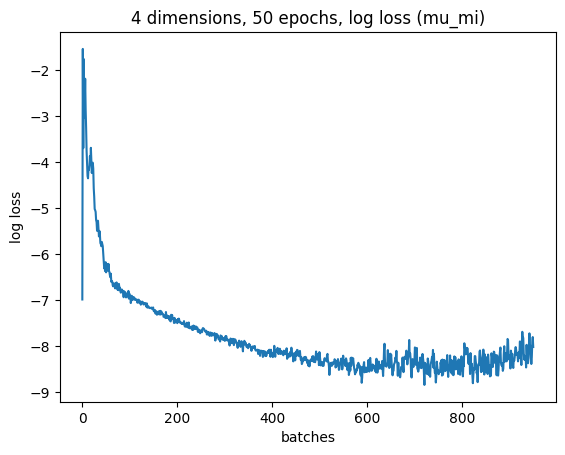

In [11]:
plt.figure()
plt.plot(np.log(torch.stack(loss_log).detach().numpy()))
plt.title("4 dimensions, 50 epochs, log loss (mu_mi)")
plt.ylabel("log loss")
plt.xlabel("batches")
plt.show()

In [12]:
# save T, mi, loss log, flattened inputs
torch.save(mine.T, 'mineT4.pth')
np.save('mi4.npy', mi)
np.save('loss_log4.npy', torch.stack(loss_log).detach().numpy())
np.save('images_flat4.npy', images_flat)
np.save('responses4d.npy', responses)

In [3]:
T = torch.load('mineT4.pth')
images_flat = np.load('images_flat4.npy')
responses = np.load('responses4d.npy')

In [4]:
Tweights = T[1].weight.detach().numpy()[:,:-1]
Tweights.shape

(4, 150528)

In [5]:
act_length = 20000
images_weighted = np.zeros((act_length, 224*224*3, 1))
for i in range(1):
    images_weighted[:,:,i] = images_flat*Tweights[i]

In [6]:
def scale_rgb(x):
    return ((x - x.min()) / (x.max() - x.min()))

In [7]:
images_weighted = np.reshape(images_weighted, (act_length, 3, 224, 224, 1))

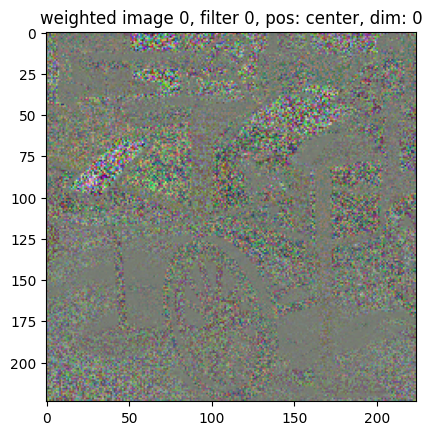

In [8]:
plt.figure()

temp = images_weighted[0, :, :, :, 0].copy()
for k in range(3):
    temp[k, :, :] = scale_rgb(temp[k, :, :])
plt.imshow(np.transpose(temp, (1, 2, 0)))
plt.title("weighted image 0, filter 0, pos: center, dim: 0")
plt.show()

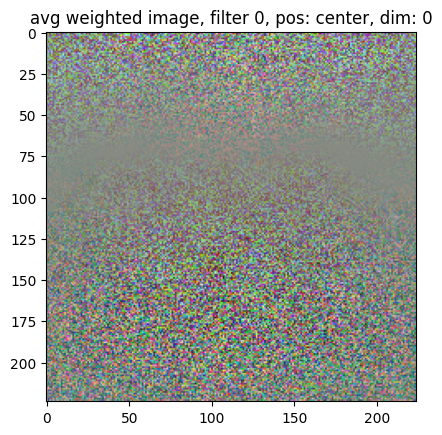

In [9]:
plt.figure()

temp = np.mean(images_weighted[:, :, :, :, 0], axis=0)
for k in range(3):
    temp[k, :, :] = scale_rgb(temp[k, :, :])
plt.imshow(np.transpose(temp, (1, 2, 0)))
plt.title("avg weighted image, filter 0, pos: center, dim: 0")
plt.show()

In [15]:
mi4 = np.load('mi4.npy')
mi3 = np.load("mi3.npy")
mi2 = np.load("mi2.npy")
mi1 = np.load("mi.npy")
mis = [mi1, mi2, mi3, mi4]
xs = np.arange(1,5)

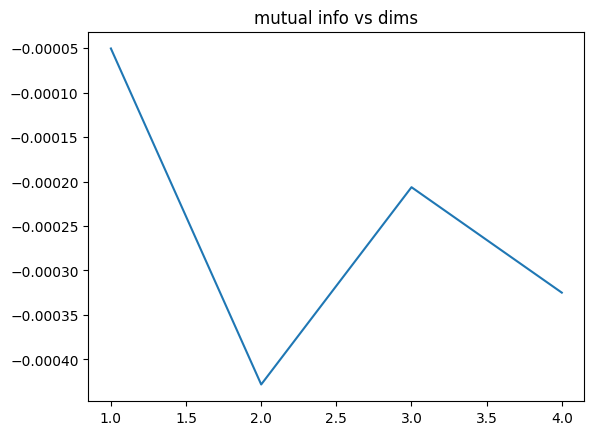

In [19]:
plt.figure()
plt.title("mutual info vs dims")
plt.plot(xs, mis)
plt.show()